In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import json

C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modelos Tradicionais (Baseline)
# 📊ARIMA
#### 💾 Carregamento e preparação da série temporal

In [2]:
df_cp = pd.read_parquet('datasets/consumo_eredes_normalizado_4610.parquet')

# Filtra os dados para o código postal 4610 e garante que as datas estão no tipo datetime e ordenadas cronologicamente.
static_feats = df_cp[["ZipCode","PopulationDensity"]].drop_duplicates()

# Extrai as static features, neste caso a densidade populacional por código postal, que não variam ao longo do tempo.
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🧪 Separação treino / teste

In [3]:
# Separa os dados em treino e teste. As últimas 24 horas são reservadas para teste (hold-out).
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [4]:
# Tenta carregar um modelo previamente treinado para reaproveitamento ou análise.
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA/modelo/")

#### 🛠️ Treinar ARIMA puro (sem covariáveis)

In [8]:
# Treina o modelo ARIMA com ordem (1,1,1) e sazonalidade diária (24 horas).
# Usa normalização (target_scaler: standard) e ignora ensemble/model selection (skip_model_selection=True) para forçar o uso exclusivo do ARIMA.
predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    path="predicts/ARIMA/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "ARIMAModel": {
            "order": (1, 1, 1),
            "seasonal_order": (1, 0, 1, 24),
            "target_scaler": "standard",
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True,    # não tenta ensembles
)

predictor_arima.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.16 GB / 7.88 GB (14.8%)
Disk Space Avail:   886.17 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (1, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 

#### 🔮 Previsão com os dados de treino

In [5]:
future_preds = predictor_arima.predict(train_data) # Gera previsões futuras com base nos dados de treino (últimas 24h).

# Extrai a previsão pontual (mediana, coluna "0.5") e remove o nível do índice correspondente ao código postal.
y_pred = future_preds["0.5"]
y_pred = y_pred.droplevel(0)

#### ✅ Preparar dados reais para comparação

In [6]:
# Cria os dados reais correspondentes ao dia 30/09/2023 para comparar com as previsões.
mask = ((df_cp["ZipCode"]=="4610") & (df_cp["DateTime"].between("2023-09-30 00:00","2023-09-30 23:00")))

df_true = df_cp.loc[mask, ["DateTime","EnergyNormalized"]] \
               .set_index("DateTime")

y_true = df_true["EnergyNormalized"]

#### 📊  Avaliação do modelo

In [7]:
# Avalia o desempenho do modelo com as métricas internas do AutoGluon.
metrics = predictor_arima.evaluate(test_data)

# Calcula métricas personalizadas: MAE, MSE, RMSE, MAPE e R2.
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (abs((y_true - y_pred) / y_true) * 100).mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("./predicts/ARIMA/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)


print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²: {r2:.5f}")

MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%
R²: -15.00898


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor   | Interpretação                                                                                                                                                                                                             |
|---------------------------------------------|---------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)               | 0.02499 | Em média, o modelo errou cerca de 0.025 unidades de consumo normalizado por hora. Embora o valor possa parecer pequeno, o gráfico indica que o erro é mais significativo durante os picos de consumo. |
| **MSE** (Erro Quadrático Médio)             | 0.00097 | O valor do erro quadrático médio mostra que há penalizações maiores quando ocorrem erros grandes (como nos picos). Este valor, apesar de pequeno, indica que o modelo teve dificuldade em captar variações mais abruptas. |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 0.03117 | O modelo tem um erro médio de cerca de 0.031 unidades de consumo, o que reforça a dificuldade em prever os padrões reais, principalmente os picos.                                                                        |
| **MAPE** (Erro Percentual Absoluto Médio)   | 47.82%  | O modelo erra em média quase 48% em relação ao valor real — um valor elevado, o que indica que o ARIMA, sem covariáveis, não é suficientemente preciso para capturar a dinâmica do consumo neste caso.                   |
| **R²**   | -15.00898  | O modelo é muito pior que a média. Não está a prever nada útil.                                                                                                                                                           |

#### 📈 Visualização dos resultados

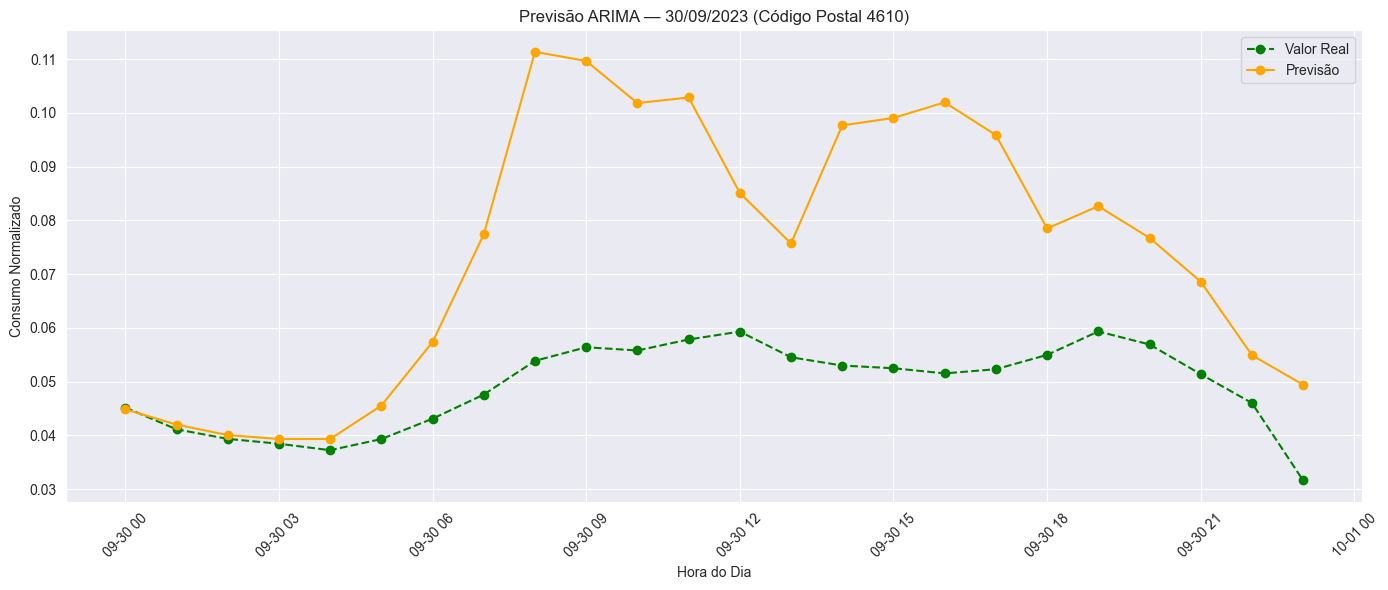

In [8]:
# Compara graficamente as previsões com os valores reais do consumo energético.
timestamps = future_preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()